In [32]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


ModuleNotFoundError: ignored

In [9]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2023-11-06 22:57:50--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   138MB/s    in 0.5s    

2023-11-06 22:57:50 (138 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size  # Set batch size to 1 for the test set
    #class_mode=None,  # No class mode for test set
    #shuffle=False  # Maintain the order for the test predictions
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


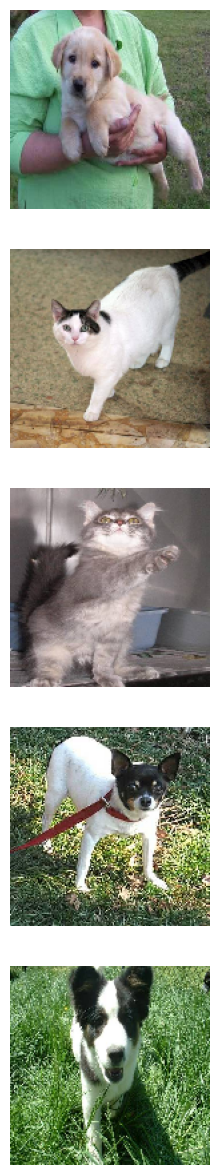

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [12]:
# 5
 # Including random transformations along with rescaling
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Setting up the generators using flow_from_directory
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical'  # Change this to your specific problem
)


Found 2000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


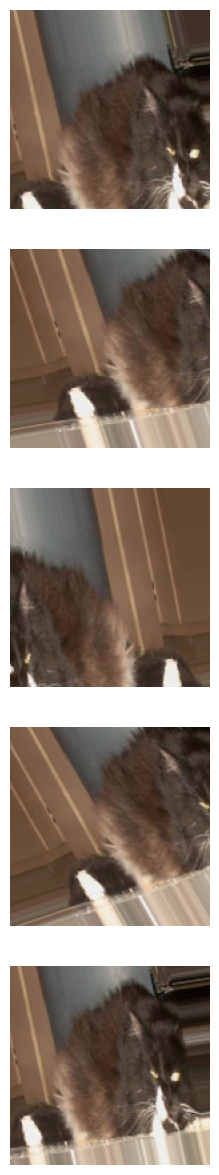

In [25]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [26]:
train_data_gen.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [42]:
model = Sequential()
num_classes = 2
# Number of epochs for training
epochs = 50
steps_per_epoch = train_data_gen.n // batch_size
validation_steps = val_data_gen.n // batch_size

# Define the hyperparameters to be tuned
learning_rates = [0.001, 0.0005, 0.0001]
neurons_list = [256, 512, 1024]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for neurons in neurons_list:
        # Define the model
        model = Sequential()
        num_classes = 2
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(neurons, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))

        # Compile the model with the current hyperparameters
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        print({'learning_rate': lr, 'neurons': neurons})
        # Train the model
        history = model.fit(
            train_data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=validation_steps,
        )

        # Get the accuracy
        accuracy = history.history['val_accuracy'][-1]

        # Check if this is the best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'neurons': neurons}

print("Best accuracy:", best_accuracy)
print("Best parameters:", best_params)

{'learning_rate': 0.001, 'neurons': 256}
Epoch 1/30
15/15 [==============================] - 17s 1s/step - loss: 0.9401 - accuracy: 0.4920 - val_loss: 0.6923 - val_accuracy: 0.5770
Epoch 2/30
15/15 [==============================] - 16s 1s/step - loss: 0.6927 - accuracy: 0.5048 - val_loss: 0.6871 - val_accuracy: 0.4955
Epoch 3/30
15/15 [==============================] - 16s 1s/step - loss: 0.6966 - accuracy: 0.5112 - val_loss: 0.6839 - val_accuracy: 0.5011
Epoch 4/30
15/15 [==============================] - 17s 1s/step - loss: 0.6934 - accuracy: 0.5486 - val_loss: 0.6920 - val_accuracy: 0.5335
Epoch 5/30
15/15 [==============================] - 19s 1s/step - loss: 0.6911 - accuracy: 0.5198 - val_loss: 0.6863 - val_accuracy: 0.5045
Epoch 6/30
15/15 [==============================] - 15s 1s/step - loss: 0.6810 - accuracy: 0.5710 - val_loss: 0.6593 - val_accuracy: 0.6094
Epoch 7/30
15/15 [==============================] - 15s 1s/step - loss: 0.6791 - accuracy: 0.5855 - val_loss: 0.6534 - 

In [50]:
# 7
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(best_params['neurons'], activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [52]:
# 8
epochs = 50

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
            train_data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=validation_steps
        )

Epoch 1/50
15/15 [==============================] - 17s 1s/step - loss: 0.7126 - accuracy: 0.5176 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 0.6895 - accuracy: 0.5385 - val_loss: 0.6700 - val_accuracy: 0.5670
Epoch 3/50
15/15 [==============================] - 15s 1s/step - loss: 0.6673 - accuracy: 0.5876 - val_loss: 0.6489 - val_accuracy: 0.6328
Epoch 4/50
15/15 [==============================] - 16s 1s/step - loss: 0.6581 - accuracy: 0.6149 - val_loss: 0.6366 - val_accuracy: 0.6551
Epoch 5/50
15/15 [==============================] - 15s 1s/step - loss: 0.6549 - accuracy: 0.6170 - val_loss: 0.6178 - val_accuracy: 0.6685
Epoch 6/50
15/15 [==============================] - 15s 989ms/step - loss: 0.6290 - accuracy: 0.6437 - val_loss: 0.6123 - val_accuracy: 0.6540
Epoch 7/50
15/15 [==============================] - 16s 1s/step - loss: 0.6163 - accuracy: 0.6536 - val_loss: 0.6416 - val_accuracy: 0.6094
Epoch 8/50
15/15 

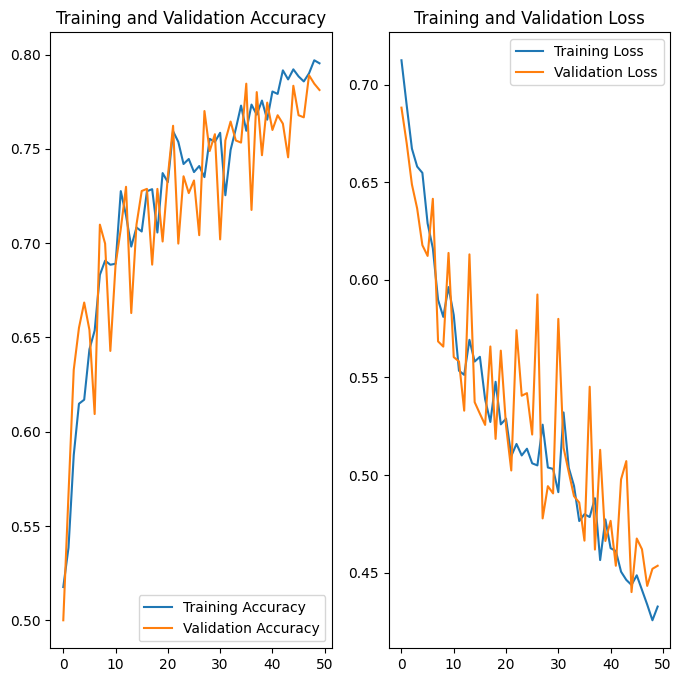

In [53]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
#10
predicted_probabilities = model.predict(test_data_gen)

# Print the predicted probabilities
print(predicted_probabilities)

ValueError: ignored

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")